# HCI 2019 Final Exam


*Matthew Kenworthy // Leiden Observatory*

This is the final exam for the HCI 2019 course.

Answer the questions fully in English in a cell after the question. There are 10 points in total on this exam.

You must email this Notebook with YOUR_NAME replaced with your name and emailed to radhakrishnan@strw.leidenuniv.nl

There is a data cube called ``hci_2019_data.fits`` and an associated file called ``rotang2.dat`` that contains angles in degrees read out from the telescope derotator.

### DEADLINE IS 11:59 on MONDAY 25 NOVEMBER

The notebook **must compile cleanly** (``Cell => All Output=> Clear`` and then ``Cell => Run All`` must produce all your graphs and plots and images without an error) and should contain all subroutines required for data reduction.
  
##  If the Notebook does **NOT** complile cleanly, you will LOSE MARKS on this Final Exam.

All graphs and plots **MUST** be labelled with quantities and units.
  

In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits

import matplotlib as mpl
mpl.rc('image', interpolation='nearest', origin='lower')

from astropy.io import ascii

# read in the data cube
im, he = fits.getdata('hci_2019_data.fits', header=True)

# read in the rotation angles
t = ascii.read('rotang2.dat',format='no_header')
rot = (t['col1']).data

In [17]:
# Useful functions

def cen_rot2 (im, rot, dim_out, offset1=(0,0), offset2=(0,0), order=2):
    """cen_rot2 - takes a cube of images im, and a set of rotation angles in rot,
                and translates the middle of the frame with a size dim_out to the middle of
                a new output frame with an additional rotation of rot.
                """
    from scipy.ndimage import affine_transform
    a = rot * np.pi / 180.
    
    # make a rotation matrix
    transform=np.array([[np.cos(a),-np.sin(a)],[np.sin(a),np.cos(a)]])
    
    # calculate total offset for image output

    # determine centre of input image

    # -0.5 is there for fencepost counting error
    c_in = np.array(offset1) - 0.5
    c_out = 0.5 * np.array(dim_out) - 0.5

    # c_out has to be pre-rotated to make offset correct
    offset = c_in - c_out.dot(transform) - np.array(offset2).dot(transform)
    
    # perform the transformation
    dst=affine_transform( \
        im,transform.T, order=order,offset=offset, \
        output_shape=dim_out, cval=0.0)
    return(dst)

def derot(imin, rotangle, out_dims, star_cen):
    # get shape of input image
    nim, nx, ny = imin.shape
    
    # make a zero value numpy array for the output
    im_out = np.zeros((nim, out_dims[0], out_dims[1]))
    
    for j, frame in enumerate(np.split(imin, nim, axis=0)):
        frame_sq = np.squeeze(frame)
        frame_rot = cen_rot2(frame_sq, rotangle[j], out_dims, offset1=star_cen)
        im_out[j,:,:] = frame_rot
        
    return(im_out)

def r_theta(im, xc, yc):
    # returns the radius rr and the angle phi for point (xc,yc)
    ny, nx = im.shape
    yp, xp = np.mgrid[0:ny,0:nx]
    yp = yp - yc
    xp = xp - xc
    rr = np.sqrt(np.power(yp,2.) + np.power(xp,2.))
    phi = np.arctan2(yp, xp)
    return(rr, phi)

def circle_mask(im, xc, yc, rcirc):
        ny, nx = im.shape
        y,x = np.mgrid[0:nx,0:ny]
        r = np.sqrt((x-xc)*(x-xc) + (y-yc)*(y-yc))
        return ( (r < rcirc))
    
def rings(im, xc, yc, ring_array):
    im_rings = np.zeros_like(im) - 1.
    
    # make inner and outer radius
    r_inner = ring_array[0:-1]
    r_outer = ring_array[1:]
    
    r, t = r_theta(im_rings, xc, yc)
    for i, (rin, rout) in enumerate(zip(r_inner, r_outer)):
        im_rings[(r >= rin) * (r < rout)] = i 
        
    r_middle = (r_inner + r_outer) / 2.
    return(im_rings, r_middle)

def derot(imin, rotangle, out_dims, star_cen):
    # get shape of input image
    nim, nx, ny = imin.shape
    
    # make a zero value numpy array for the output
    im_out = np.zeros((nim, out_dims[0], out_dims[1]))
    
    for j, frame in enumerate(np.split(imin, nim, axis=0)):
        frame_sq = np.squeeze(frame)
        frame_rot = cen_rot2(frame_sq, rotangle[j], out_dims, offset1=star_cen)
        im_out[j,:,:] = frame_rot
        
    return(im_out)
def wfits(im, fname):
    """wfits - write im to file fname, 
    automatically overwriting any old file"""
    from astropy.io import fits
    hea = fits.PrimaryHDU(im)
    hea.writeto(fname, overwrite=True)
    
def zoom(im,x,y,bb):
    '''returns a square 2D image cut out from im centered on location (x,y) and with half-width bb'''
    return(im[y-bb:y+bb,x-bb:x+bb])

**Q1 (1 point):** What diversity is being used in this data?

In [18]:
# Q1 answer
# Angular Diversity

**Q2 (1 point):** The data is saturated in the middle of the image - due to the nature of the detector readout, the star flux appears to decrease where the star image has the largest flux. By visual inspection, look at the image cube and estimate the radius in pixels which should be ignored in the data processing. To be safe, you should ignore large flux pixels close to the centre of the image just in case they are in a nonlinear regime of the detector.

Choose one of the images in the data cube, display it and draw a yellow circle centered on the star and with the radius of your estimate of where the data is saturated out to. The data within this circle should be ignored in all subsequent data reduction.

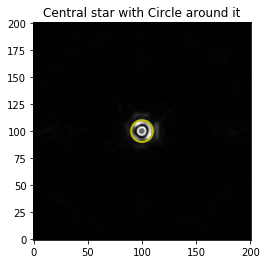

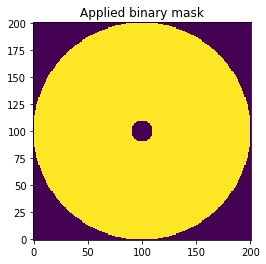

In [19]:
# Q2 answer
#Center = 101,101 from ds9
#r = 10

plt.imshow(im[1],cmap='gray')
star = plt.Circle((100,100),10,color='y',fill=False,linewidth=2)
plt.gca().add_artist(star)
plt.title('Central star with Circle around it')
plt.show()

r_ring = np.array([10,100])
ann_mask, r_rad = rings(im[1], 100,100,r_ring)

plt.imshow(ann_mask)
plt.title('Applied binary mask')
plt.show()

**Q3 (4 points):** Reduce the data cube using one of the algorithms covered in the course and produce a final reduced image with the central star in the centre of the image. Show the location of the planet using a red circle in your final reduced image. You should use a mask made from the radius determined in Q2 to exclude the saturated data.

In [20]:
# Q3 answer
ann_mask += 1
ann_mask = ann_mask.astype(bool)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


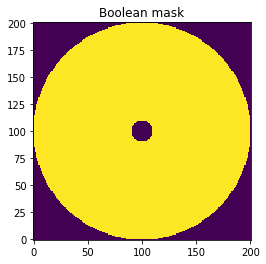

In [21]:
print(ann_mask)
plt.imshow(ann_mask)
plt.title('Boolean mask')
plt.show()

In [22]:
print('Image cube shape',im.shape)
im_swap = np.swapaxes(im,0,2)
print('Image shape after swap',im_swap.shape)
A = im_swap[ann_mask]
print('Vector shape',A.shape)

Image cube shape (96, 201, 201)
Image shape after swap (201, 201, 96)
Vector shape (31092, 96)


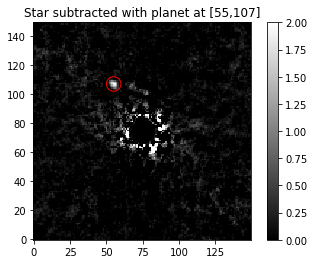

In [23]:
median = np.median(A,axis=1)
Amedsub = im_swap[ann_mask] - median[:,np.newaxis]

cube = np.zeros_like(im_swap)
cube[:][:][:][ann_mask] = Amedsub
cube = np.swapaxes(cube,0,2)

p_coord = [55,107]

ADImed = np.median(derot(cube,rot,(150,150),(100,100)),axis=0)
wfits(ADImed,'ADImed.fits')
plt.imshow(ADImed,vmin = 0,vmax = 2,cmap = 'gray')
planet = plt.Circle((p_coord[0],p_coord[1]),5,color='r',fill=False) #Coordinates found from .fits file
plt.gca().add_artist(planet)
plt.title('Star subtracted with planet at [%s,%s]'%(p_coord[0],p_coord[1]))
plt.colorbar()
plt.show()

**Q4 (1 point):** Determine the angular separation in pixels between the planet and star to an accuracy of 1 pixel. Print out this distance using a formatted print statement. Display an image of the planet zoomed in to a size of a square box with 20 pixels to demonstrate you've identified the planet.

In [24]:
# Q4 answer
import astropy.units as u
from uncertainties import ufloat

ppos = np.array([56,107]) * u.pix
spos = np.array([100,100]) * u.pix

dist = np.sqrt((ppos[0] - spos[0])**2 + (ppos[1] - spos[1])**2)
print('Pixel distance from star to planet =',dist)
diste = ufloat(dist / u.pix, 1)
print('Pixel distance with error =',diste)

Pixel distance from star to planet = 44.553338819890925 pix
Pixel distance with error = 44.6+/-1.0


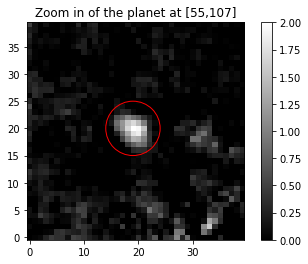

In [25]:
plt.imshow(zoom(ADImed,56,107,20),cmap='gray',vmin=0,vmax=2)
planet_zoom = plt.Circle((19,20),5,color='r',fill=False)
plt.gca().add_artist(planet_zoom)
plt.title('Zoom in of the planet at [%s,%s]'%(p_coord[0],p_coord[1]))
plt.colorbar()
plt.show()

**Q5 (1 point):** Assuming a pixel scale of $12.25\pm 0.05$ milliarcsec per pixel, determine the angular separation of the planet in arcseconds with an appropriate quoted error. Print using a formatted print statement.

In [26]:
# Q5 answer
# mlliarcseconds => u.mas

pix_scale = 12.25 * u.mas / u.pix
ang_dist = dist * pix_scale
# print(ang_dist)

pix_scale_err = ufloat(pix_scale * u.pix / u.mas, 0.05)

ang_dist_err = diste * pix_scale_err
print('Angular Seperation =',ang_dist_err,'mas')


Angular Seperation = 546+/-12 mas


**Q6 (2 points):** Measure the flux of the planet using an aperture that is 100 milliarcseconds in diameter and centered on the planet. Print using a formatted print statement. 

Remember to estimate the sky background using a similar sized aperture at the same angular distance from the star but close to the location of the planet. 

Print the r.m.s. per pixel in the sky background aperture, and print the planet flux corrected for the sky background level.

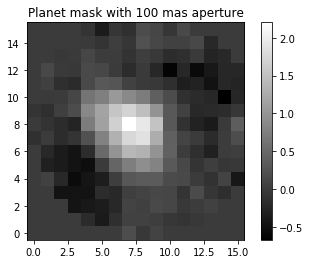

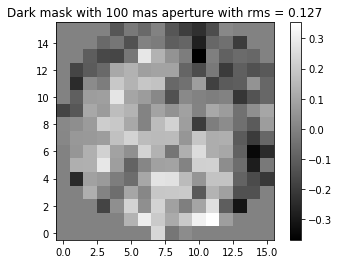

Total flux with sky subtraction =  20.68423120684341
Pixel RMS of dark zone =  0.12744321509150763


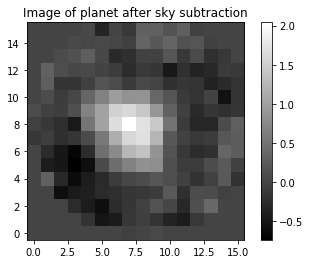

In [27]:
# Q6 answer
aperture = 100 * u.mas
ap_to_pix = aperture / pix_scale
aperture_d = ap_to_pix / u.pix
# print(ap_to_pix)

planet_mask = circle_mask(ADImed,56,107,aperture_d)
planet_im = ADImed * planet_mask
planet_zoom = zoom(planet_im,56,107,int(aperture_d))

plt.imshow(planet_zoom,cmap='gray')
plt.title('Planet mask with 100 mas aperture')
plt.colorbar()
plt.show()

dark_mask = circle_mask(ADImed,40,31,aperture_d) #Dark / sky patch found in ds9
dark_im = ADImed * dark_mask
dark_zoom =zoom(dark_im,40,31,int(aperture_d))

plt.imshow(dark_zoom,cmap='gray')
plt.title('Dark mask with 100 mas aperture with rms = %.3f' % np.std(dark_zoom))
plt.colorbar()
plt.show()


# psum = np.sum(planet_zoom) - np.sum(dark_zoom)

psum = np.sum(planet_zoom - dark_zoom)
print('Total flux with sky subtraction = ',psum)
print('Pixel RMS of dark zone = ',np.std(dark_zoom))

plt.imshow(planet_zoom - dark_zoom,cmap = 'gray')
plt.colorbar()
plt.title('Image of planet after sky subtraction')
plt.show()